In [2]:
import pandas as pd
import torch
from joblib import delayed, Parallel
from tqdm import tqdm

In [18]:
df = pd.read_parquet('/home/l2hebert/reddit-text/data-super-filtered.parquet')

In [19]:
df.groupby(['subreddit']).nunique()

,index,body,path,link_id,new_index,idx_path
subreddit,,,,,,
AmItheAsshole,1032,1281683,54111,54111,1,54111
IAmA,630,28700,495,495,1,495
The_Donald,10342,2639289,115583,115583,1,115583
climateskeptics,318,14060,952,952,1,952
politics,11429,1356828,42189,42189,1,42189


In [20]:
df.groupby('subreddit').count()

,index,body,path,link_id,new_index,idx_path
subreddit,,,,,,
AmItheAsshole,1381200,1381200,1381200,1381200,1381200,1381200
IAmA,30415,30415,30415,30415,30415,30415
The_Donald,3005612,3005612,3005612,3005612,3005612,3005612
climateskeptics,14753,14753,14753,14753,14753,14753
politics,1457321,1457321,1457321,1457321,1457321,1457321


In [34]:
subset = df.loc[df['subreddit'] == 'IAmA']

In [35]:
subset.groupby('link_id').ngroups

495

In [5]:
subset = df[['link_id', 'subreddit']]

In [16]:
df['subreddit'].value_counts()

The_Donald         3005612
politics           1457321
AmItheAsshole      1381200
IAmA                 30415
climateskeptics      14753
Name: subreddit, dtype: int64

In [13]:
subset

,index,body,path,link_id,subreddit,new_index,idx_path
5,0,"Herman Cain was leading too at one point, and ...",/home/l2hebert/reddit-graph/The_Donald/16632/3...,3dgpjk,The_Donald,1,data_2.pt
6,1,"Yeah but when he announced, I bet you dismisse...",/home/l2hebert/reddit-graph/The_Donald/16632/3...,3dgpjk,The_Donald,1,data_2.pt
7,2,[deleted],/home/l2hebert/reddit-graph/The_Donald/16632/3...,3dgpjk,The_Donald,1,data_2.pt
8,3,"You are so political savvy, maybe you should b...",/home/l2hebert/reddit-graph/The_Donald/16632/3...,3dgpjk,The_Donald,1,data_2.pt
9,4,"LOOOOOL\n\n**McCain**\n\n""Our economy, I think...",/home/l2hebert/reddit-graph/The_Donald/16632/3...,3dgpjk,The_Donald,1,data_2.pt
...,...,...,...,...,...,...,...
3173051,1,Because George Soros told him to do it.,/home/l2hebert/reddit-graph/The_Donald/17074/5...,55asjh,The_Donald,1,data_193572.pt
3173052,2,"He is a traitor. He does not work for America,...",/home/l2hebert/reddit-graph/The_Donald/17074/5...,55asjh,The_Donald,1,data_193572.pt
3173053,3,It makes it possible to pressure the big corpo...,/home/l2hebert/reddit-graph/The_Donald/17074/5...,55asjh,The_Donald,1,data_193572.pt
3173054,4,He is courting the UN so I'm sure it is part o...,/home/l2hebert/reddit-graph/The_Donald/17074/5...,55asjh,The_Donald,1,data_193572.pt


In [6]:
subset.loc[subset['subreddit'] == 'The_Donald']

,link_id,subreddit
5,3dgpjk,The_Donald
6,3dgpjk,The_Donald
7,3dgpjk,The_Donald
8,3dgpjk,The_Donald
9,3dgpjk,The_Donald
...,...,...
3173051,55asjh,The_Donald
3173052,55asjh,The_Donald
3173053,55asjh,The_Donald
3173054,55asjh,The_Donald


In [21]:
grouped = df.groupby('link_id')

In [22]:
def compute_skip(group):
    path = group['path'].iloc[0]
    data = torch.load(path)
    # max_index = data.edge_index[0, :].max()
    # shape = data.x.size(0)
    group['y'] = torch.argmax(data.y, dim=1).numpy()
    group['size'] = len(group)
    # if (shape > max_index):
    #     group['skip'] = False 
    # else:
    #     group['skip'] = True 
    
    return group

result_dfs = Parallel(n_jobs=1)(delayed(compute_skip)(group) for name, group in tqdm(grouped, mininterval=1, total=grouped.ngroups))
result = pd.concat(result_dfs)

100%|██████████| 213330/213330 [06:36<00:00, 537.38it/s]


In [29]:
result[['subreddit', 'y']].groupby(['subreddit', 'y']).size().unstack(fill_value=0)

y,0,1,2,3,4
subreddit,,,,,
AmItheAsshole,1103308,183108,39815,45371,9598
IAmA,27890,2240,216,68,1
The_Donald,2310601,441746,133534,117091,2640
climateskeptics,12125,2491,132,5,0
politics,1087286,264570,54311,45563,5591


In [14]:
(0.25 - result['y']).mean()

-0.06656747755574863

In [55]:
result = pd.concat(result_dfs)

In [56]:
result = result.loc[result['size'] <= 300]

In [57]:
result['y'].value_counts()

0    3815563
1     801693
2     207292
3     174852
4       6404
Name: y, dtype: int64

In [58]:
res = result.groupby('link_id')['y'].apply(lambda x: (x == 0).all())

In [59]:
res2 = result.merge(res, on='link_id', how='left')

In [65]:
res3 = res2.loc[~res2['y_y']]

In [66]:
res3['y_x'].value_counts()

0    3200812
1     801693
2     207292
3     174852
4       6404
Name: y_x, dtype: int64

In [69]:
res3 = res3.drop(['y_y', 'size'], axis=1)

In [70]:
res3 = res3.rename({'y_x': 'y'})

In [71]:
res3.to_parquet('/home/l2hebert/reddit-text/data-super-filtered2.parquet')

In [72]:
len(res3.groupby('link_id'))

139652

In [14]:
import sklearn

In [9]:
df = df.groupby('link_id')

In [14]:
def compute_all_0(group):
    path = group['path'].iloc[0]
    data = torch.load(path)
    # max_index = data.edge_index[0, :].max()
    # shape = data.x.size(0)
    group['y'] = torch.argmax(data.y, dim=1).numpy()
    # if (shape > max_index):
    #     group['skip'] = False 
    # else:
    #     group['skip'] = True 
    
    return group

result_dfs = Parallel(n_jobs=-1)(delayed(compute_all_0)(group) for name, group in tqdm(df, mininterval=1, total=df.ngroups))
result = pd.concat(result_dfs)

100%|██████████| 213330/213330 [23:01<00:00, 154.39it/s]


In [22]:
(0.30 - result['y']).abs().mean()

0.5100300867426869

In [ ]:
result.groupby['link_id']

<AxesSubplot:>

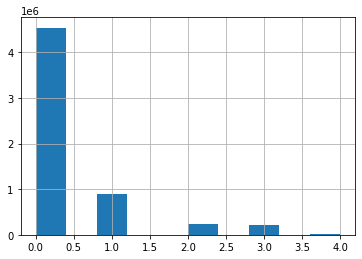

In [26]:
result['y'].hist()

In [74]:
import sklearn

In [76]:
res3.columns

Index(['index', 'body', 'path', 'link_id', 'subreddit', 'new_index',
       'idx_path', 'y_x'],
      dtype='object')

In [77]:
weights = sklearn.utils.class_weight.compute_class_weight('balanced', classes=[0, 1, 2, 3, 4], y=res3['y_x'])

In [78]:
weights

array([  0.27437119,   1.09544501,   4.23658704,   5.02259397,
       137.13469706])

In [15]:
size_before = len(result)
result = result.loc[~result['skip']]
size_after = len(result)
print(size_before - size_after)

1398595


In [20]:
result['idx'] = result.groupby(['link_id']).ngroup()

In [21]:
result['idx_path'] = f'data_' + result['idx'].astype(str) + '.pt'

In [22]:
result.to_parquet('/home/l2hebert/reddit-text/data-filtered.parquet')

In [37]:
res = result.groupby(['link_id'], as_index=False).size()
result = result.merge(res, on='link_id', how='left')
after = result.loc[result['size_y'] > 3]

In [41]:
after.groupby('link_id').ngroups

213330

In [44]:
after = after.drop(['skip', 'idx'], axis=1)

after.to_parquet('/home/l2hebert/reddit-text/data-super-filtered.parquet')

In [27]:
result['size']

0      NaN
1      NaN
2      NaN
4      NaN
5      NaN
        ..
4288   NaN
4461   NaN
4471   NaN
4653   NaN
4657   NaN
Name: size, Length: 6102873, dtype: float64

In [24]:
result.groupby('link_id').ngroups

313959

In [49]:
after['idx_path']

5               data_2.pt
6               data_2.pt
7               data_2.pt
8               data_2.pt
9               data_2.pt
                ...      
6102868    data_313958.pt
6102869    data_313958.pt
6102870    data_313958.pt
6102871    data_313958.pt
6102872    data_313958.pt
Name: idx_path, Length: 5889301, dtype: object

In [1]:
import pandas as pd
import numpy as np

In [4]:
np.random.seed(1)

In [5]:
df = pd.read_parquet('/home/l2hebert/reddit-text/data-super-filtered.parquet')

In [8]:
df.columns

Index(['index', 'body', 'path', 'link_id', 'subreddit', 'new_index',
       'idx_path'],
      dtype='object')